In [1]:
import py4DSTEM as p4
from pathlib import Path
import os

# print(os.getcwd())

path = Path("Datasets/Diffraction_SI/Diffraction_SI.dm4")

dc = p4.io.import_file(path,                 # auto-detects “dm” type
                       mem='MEMMAP')         # or 'RAM' for small cubes
print(dc)       # -> (Ny, Nx, Nq_y, Nq_x) plus rich metadata
print(dc.shape)


DataCube( A 4-dimensional array of shape (42, 114, 512, 512) called 'dm_dataset',
          with dimensions:

              Rx = [0.0,0.49195072054862976,0.9839014410972595,...] nm
              Ry = [0.0,0.49195072054862976,0.9839014410972595,...] nm
              Qx = [0.0,0.016712141036987305,0.03342428207397461,...] A^-1
              Qy = [0.0,0.016712141036987305,0.03342428207397461,...] A^-1
)
(42, 114, 512, 512)


Raw shape: (42, 114, 512, 512)
Dtype   : uint8
Min / Max      : 0 177
Mean / Std-dev : 0.16203388494556908 2.1282028202261274


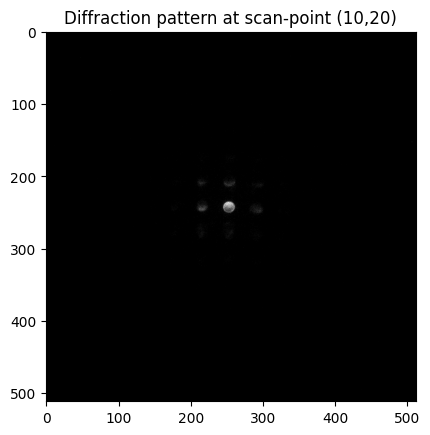

In [3]:
# .data is a numpy array of shape (Ny, Nx, Nqy, Nqx)
arr = dc.data
print("Raw shape:", arr.shape)
print("Dtype   :", arr.dtype)

# quick EDA
import numpy as np
print("Min / Max      :", arr.min(), arr.max())
print("Mean / Std-dev :", arr.mean(), arr.std())

# visualise one diffraction pattern at (iy, ix) = (10, 20)
import matplotlib.pyplot as plt
plt.imshow(arr[10, 20], cmap="gray")
plt.title("Diffraction pattern at scan-point (10,20)")
plt.show()


Min / Max : 0 135


Text(0.5, 1.0, 'log-scale: grey=low, white=high')

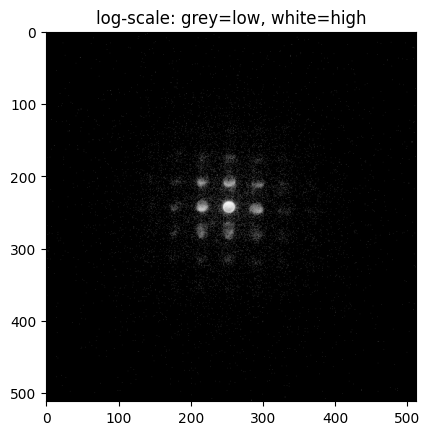

In [4]:
dp = arr[10, 20]
print("Min / Max :", dp.min(), dp.max())
plt.imshow(np.log1p(dp), cmap='gray')
plt.title("log-scale: grey=low, white=high")


Active q-range: 0:512 × 0:512


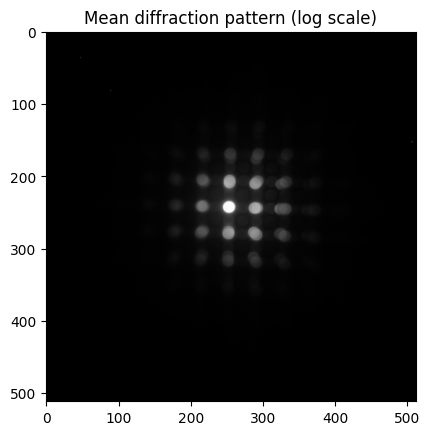

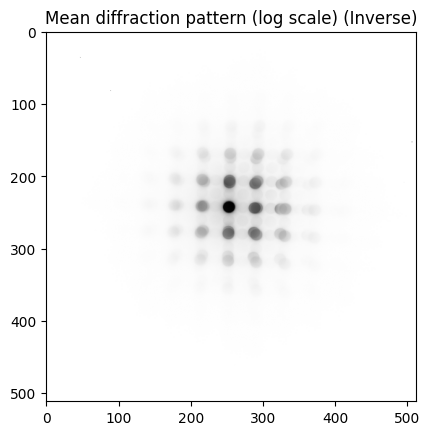

In [5]:
# Boolean mask of non-zero pixels
nz = dp > 0

# Bounding box of the active detector area
qy_idx = np.where(nz.any(axis=1))[0]
qx_idx = np.where(nz.any(axis=0))[0]

print("Active q-range:",
      f"{qy_idx.min()}:{qy_idx.max()+1} × {qx_idx.min()}:{qx_idx.max()+1}")

mean_dp = arr.mean(axis=(0, 1))
plt.imshow(np.log1p(mean_dp), cmap='gray')
plt.title("Mean diffraction pattern (log scale)")
plt.show()

plt.imshow(np.log1p(mean_dp), cmap='gray_r')
plt.title("Mean diffraction pattern (log scale) (Inverse)")
plt.show()


In [6]:
sat_level = np.iinfo(arr.dtype).max   # e.g. 65535 for uint16
n_sat = np.count_nonzero(arr == sat_level)
print(f"Saturated pixels in entire cube: {n_sat:,}")


Saturated pixels in entire cube: 0


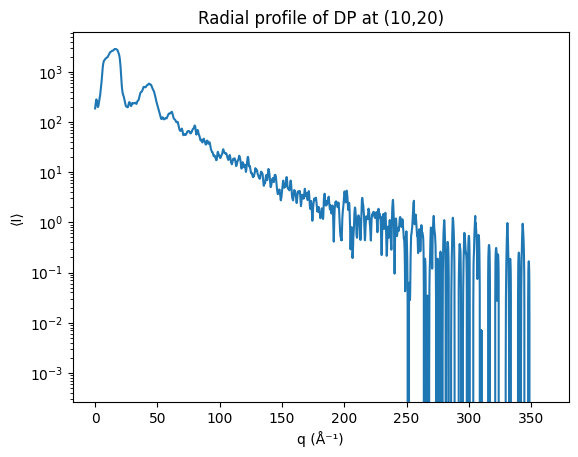

In [7]:
from py4DSTEM.process.utils.elliptical_coords import radial_integral  
# pick one pattern
dp = arr[10, 20]

# if you have a calibrated beam centre (x0, y0), e.g. from:
#   origin = dc.calibration.origin  
# or by
#   from py4DSTEM.process.calibration.ellipse import get_origin
#   origin = get_origin(dp)
#
# then feed dp and that centre into radial_integral:

q, I = radial_integral(dp)

# q is the array of radii (in Å⁻¹ or px), I is ⟨I⟩(q)
import matplotlib.pyplot as plt
plt.semilogy(q, I)
plt.xlabel("q (Å⁻¹)")
plt.ylabel("⟨I⟩")
plt.title("Radial profile of DP at (10,20)")
plt.show()


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import hyperspy.api as hs
import torch

from m3_learning.nn.random import random_seed
from m3_learning.nn.STEM_AE.Viz import Viz
from m3_learning.nn.STEM_AE.STEM_AE import VariationalAutoencoder
from m3_learning.viz.style import set_style
from m3_learning.viz.printing import printer
from m3_learning.viz.Movies import make_movie
from m3_learning.nn.STEM_AE.Dataset import STEM_Dataset
from m3_learning.util.file_IO import download_and_unzip

# Specify the filename and the path to save the file
save_path = 'Savedata/STEM_VAE_Data'
fig_path = save_path.replace("Data", "Figures") + '/'

# builds the printer object
printing = printer(basepath=fig_path,fileformats=['png','svg'],verbose=False)

# Set the style of the plots
set_style("printing")

# Set the random seed for reproducibility
random_seed(seed=42)

printing set for seaborn
Pytorch seed was set to 42
Numpy seed was set to 42
tensorflow seed was set to 42


In [9]:
# crop datacube and save as .hspy for hyperspy
qy0, qy1 = qy_idx.min(), qy_idx.max()+1
qx0, qx1 = qx_idx.min(), qx_idx.max()+1

dc_crop = dc[:, :, qy0:qy1, qx0:qx1]
arr = dc_crop.data      # shape (Ny, Nx, Nqy, Nqx)

# (b) wrap as a 4D Hyperspy Signal2D
s = hs.signals.Signal2D(arr)

# (c) propagate your calibration metadata
#    (e.g. beam centre, pixel sizes) into s.axes_manager here…

# (d) save to .hspy
s.save(f"Savedata/STEM_VAE_Data/scanner_ROI_{qy0}_{qy1}.hspy")
s.save(f"Savedata/STEM_VAE_Data/uncropped.hspy")

In [3]:
# loads the dataset
# this object will also compute the log of the dataset
# this is available as self.log_data
# vortex = STEM_Dataset(
#     data_path=f"{save_path}/scanner_ROI_0_512.hspy"
# )
vortex = STEM_Dataset(
    data_path=f"{save_path}/uncropped.hspy"
)

In [4]:
# instantiates the visualization class
viz = Viz(printer=printing, labelfigs_=True)
viz.scalebar_ = {"width": 512, "scale length": 100, "units": "nm", "channel": -1}

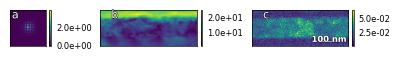

In [5]:
bright_field_ = (246, 266, 246, 266)
dark_field_ = (300, 330, 100, 130)
filename = "STEM_raw_and_virtual_vortex_domains"
viz.scalebar_ = {"width": 512, "scale length": 100, "units": "nm"}
viz.STEM_raw_and_virtual(
    vortex,
    bright_field_=bright_field_,
    dark_field_=dark_field_,
    scalebar_=True,
    filename=filename,
    shape_=vortex.data.shape,
)

In [13]:
print(dc.shape)
print(vortex.data.shape)

(42, 114, 512, 512)
(42, 114, 512, 512)


In [6]:
encoder_step_size = [256, 256]
pooling_list = [4, 4, 2]
decoder_step_size = [8, 8]
upsampling_list = [2, 4, 4]
embedding_size = 32
conv_size = 128
checkpoints_folder = 'saved_weights/STEM_VAE_Data/downloaded_weights'


# set device to load model
device = "cpu"
if torch.cuda.is_available():
    device = "cuda:0"

model = VariationalAutoencoder(
    encoder_step_size=encoder_step_size,
    pooling_list=pooling_list,
    decoder_step_size=decoder_step_size,
    upsampling_list=upsampling_list,
    embedding_size=embedding_size,
    conv_size=conv_size,
    device=device,
    learning_rate=3e-5,
)

In [29]:
from m3_learning.util.file_IO import download_and_unzip
# # weights to download from zenodo
# # uncomment this if you need to download the files from zenodo
files = ['Weight_epoch:0000_l1coef:0.0000_lr:0.00003_trainloss:0.7382.pkl',
 'Weight_epoch:0001_l1coef:0.0000_lr:0.00003_trainloss:0.7314.pkl',
 'Weight_epoch:0002_l1coef:0.0000_lr:0.00003_trainloss:0.7312.pkl',
 'Weight_epoch:0003_l1coef:0.0000_lr:0.00003_trainloss:0.7310.pkl',
 'Weight_epoch:0004_l1coef:0.0000_lr:0.00003_trainloss:0.7308.pkl',
 'Weight_epoch:0005_l1coef:0.0000_lr:0.00003_trainloss:0.7307.pkl',
 'Weight_epoch:0006_l1coef:0.0000_lr:0.00003_trainloss:0.7307.pkl',
 'Weight_epoch:0007_l1coef:0.0000_lr:0.00003_trainloss:0.7307.pkl',
 'Weight_epoch:0008_l1coef:0.0000_lr:0.00003_trainloss:0.7307.pkl',
 'Weight_epoch:0009_l1coef:0.0000_lr:0.00003_trainloss:0.7308.pkl',
 'Weight_epoch:0010_l1coef:0.0000_lr:0.00003_trainloss:0.7308.pkl',
 'Weight_epoch:0011_l1coef:0.0000_lr:0.00003_trainloss:0.7309.pkl',
 'Weight_epoch:0012_l1coef:0.0000_lr:0.00003_trainloss:0.7309.pkl',
 'Weight_epoch:0013_l1coef:0.0000_lr:0.00003_trainloss:0.7310.pkl',
 'Weight_epoch:0014_l1coef:0.0000_lr:0.00003_trainloss:0.7310.pkl',
 'Weight_epoch:0015_l1coef:0.0000_lr:0.00003_trainloss:0.7311.pkl',
 'Weight_epoch:0016_l1coef:0.0000_lr:0.00003_trainloss:0.7312.pkl',
 'Weight_epoch:0017_l1coef:0.0000_lr:0.00003_trainloss:0.7312.pkl',
 'Weight_epoch:0018_l1coef:0.0000_lr:0.00003_trainloss:0.7313.pkl',
 'Weight_epoch:0019_l1coef:0.0000_lr:0.00003_trainloss:0.7313.pkl',
 'Weight_epoch:0020_l1coef:0.0000_lr:0.00003_trainloss:0.7313.pkl',
 'Weight_epoch:0021_l1coef:0.0000_lr:0.00003_trainloss:0.7314.pkl',
 'Weight_epoch:0022_l1coef:0.0000_lr:0.00003_trainloss:0.7314.pkl',
 'Weight_epoch:0023_l1coef:0.0000_lr:0.00003_trainloss:0.7315.pkl',
 'Weight_epoch:0024_l1coef:0.0000_lr:0.00003_trainloss:0.7315.pkl',
 'Weight_epoch:0025_l1coef:0.0000_lr:0.00003_trainloss:0.7316.pkl',
 'Weight_epoch:0026_l1coef:0.0000_lr:0.00003_trainloss:0.7316.pkl',
 'Weight_epoch:0027_l1coef:0.0000_lr:0.00003_trainloss:0.7317.pkl']

# # downloads all the files
for file in files:
#     # Download the data file from Zenodo
    url = f"https://zenodo.org/record/10092102/files/{file}?download=1"

#     # download the file
#     download_and_unzip(file, url, save_path)
# # url = f"https://zenodo.org/api/records/10092102/files-archive"

# # # download the file
    download_and_unzip(file, url, save_path+'downloaded_weights/')

downloading data
...59%, 32 MB, 4734 KB/s, 6 seconds passed

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



...100%, 53 MB, 5931 KB/s, 9 seconds passeddownloading data
...100%, 53 MB, 2995 KB/s, 18 seconds passeddownloading data
...50%, 27 MB, 5628 KB/s, 4 seconds passed

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



...100%, 53 MB, 6166 KB/s, 8 seconds passeddownloading data
...100%, 53 MB, 4121 KB/s, 13 seconds passeddownloading data
...46%, 25 MB, 7333 KB/s, 3 seconds passed

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



...98%, 53 MB, 7054 KB/s, 7 seconds passed

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



...44%, 23 MB, 7572 KB/s, 3 seconds passed

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



...100%, 53 MB, 8628 KB/s, 6 seconds passeddownloading data
...100%, 53 MB, 4983 KB/s, 11 seconds passeddownloading data
...100%, 53 MB, 2425 KB/s, 22 seconds passeddownloading data
...45%, 24 MB, 7187 KB/s, 3 seconds passed

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



...69%, 37 MB, 7235 KB/s, 5 seconds passed

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



...100%, 53 MB, 7767 KB/s, 7 seconds passeddownloading data
...55%, 29 MB, 4062 KB/s, 7 seconds passed

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



...100%, 53 MB, 5217 KB/s, 10 seconds passeddownloading data
...100%, 53 MB, 3248 KB/s, 17 seconds passeddownloading data
...36%, 19 MB, 10181 KB/s, 1 seconds passed

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



...100%, 53 MB, 10118 KB/s, 5 seconds passeddownloading data
...0%, 0 MB, 2147 KB/s, 0 seconds passed

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



...85%, 46 MB, 4886 KB/s, 9 seconds passed

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



...100%, 53 MB, 5055 KB/s, 10 seconds passeddownloading data
...59%, 32 MB, 5421 KB/s, 6 seconds passed

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



...100%, 53 MB, 6810 KB/s, 8 seconds passeddownloading data
...100%, 53 MB, 4739 KB/s, 11 seconds passeddownloading data
...49%, 26 MB, 6480 KB/s, 4 seconds passed

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



...100%, 53 MB, 6945 KB/s, 7 seconds passeddownloading data
...61%, 33 MB, 5590 KB/s, 6 seconds passed

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



...89%, 48 MB, 6656 KB/s, 7 seconds passed

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



...100%, 53 MB, 4247 KB/s, 13 seconds passeddownloading data
...100%, 53 MB, 3970 KB/s, 13 seconds passeddownloading data
...60%, 32 MB, 4439 KB/s, 7 seconds passed

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



...100%, 53 MB, 5489 KB/s, 10 seconds passeddownloading data
...100%, 53 MB, 4375 KB/s, 12 seconds passeddownloading data
...30%, 16 MB, 12613 KB/s, 1 seconds passed

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



...100%, 53 MB, 11384 KB/s, 4 seconds passeddownloading data
...44%, 24 MB, 7467 KB/s, 3 seconds passed

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



...100%, 53 MB, 8169 KB/s, 6 seconds passeddownloading data
...53%, 28 MB, 6240 KB/s, 4 seconds passed

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



...100%, 53 MB, 7287 KB/s, 7 seconds passeddownloading data
...26%, 14 MB, 7044 KB/s, 2 seconds passed

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



...58%, 31 MB, 10940 KB/s, 2 seconds passed

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



downloading data
...52%, 28 MB, 5683 KB/s, 5 seconds passed

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



...100%, 53 MB, 5957 KB/s, 9 seconds passeddownloading data
...43%, 23 MB, 10962 KB/s, 2 seconds passed

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



...43%, 23 MB, 10160 KB/s, 2 seconds passed

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



...100%, 53 MB, 9538 KB/s, 5 seconds passed

In [7]:
# set retrain parameter
# manually change beta if you incremented it
weights_folder = "Savedata/STEM_VAE_Data/saved_weights/STEM_VAE_Data"
train = False
if train:
    model.Train(
        vortex.log_data,
        epochs=1,
        with_scheduler=False,
        folder_path=f'{save_path}/{checkpoints_folder}',
        batch_size=16,
        beta=0,
        beta_schedule=[5e-4,1]
    )

else:
    model.load_weights(
        f'{weights_folder}/Weight_epoch:0027_l1coef:0.0000_lr:0.00003_trainloss:0.7317.pkl'
        )

In [8]:
embeddings_folder = "Savedata/STEM_VAE_Data/saved_weights/embeddings"
model.write_multi_embeddings(input_folder = weights_folder,
                            output_folder = weights_folder,
                            input_data = vortex.log_data,
                            output_filename = 'embeddings.h5',
                            batch_size=16,
                            overwrite=True)

Weight_epoch:0000_l1coef:0.0000_lr:0.00003_trainloss:0.7382


  0%|          | 0/300 [00:11<?, ?it/s]


TypeError: Can't broadcast (64, 32) -> (16, 32)

In [1]:
import py4DSTEM as p4
from pathlib import Path
import os

# print(os.getcwd())
# 
# import sys
# # if you git-cloned the m3_larning repository, add the location of the src folder to your system path
# where_m3_saved = '/Users/louisg/PycharmProjects/m3-learning-m3_learning-dc4a2d5/m3_learning/src'
# sys.path.append(f'{where_m3_saved}')

!pip install -e '/Users/louisg/PycharmProjects/m3-learning-m3_learning-dc4a2d5/m3_learning'

# if you want the dev version of torch for faster native on MacOSX
# !pip uninstall torch torchvision torchaudio 
# !pip3 install --pre torch torchvision torchaudio --index-url https://download.pytorch.org/whl/nightly/cpu

!pip freeze

Obtaining file:///Users/louisg/PycharmProjects/m3-learning-m3_learning-dc4a2d5/m3_learning
  Preparing metadata (setup.py) ... done
  Attempting uninstall: m3_learning
    Found existing installation: m3_learning 0.0.24
    Uninstalling m3_learning-0.0.24:
      Successfully uninstalled m3_learning-0.0.24
  DEPRECATION: Legacy editable install of m3_learning==0.0.24 from file:///Users/louisg/PycharmProjects/m3-learning-m3_learning-dc4a2d5/m3_learning (setup.py develop) is deprecated. pip 25.3 will enforce this behaviour change. A possible replacement is to add a pyproject.toml or enable --use-pep517, and use setuptools >= 64. If the resulting installation is not behaving as expected, try using --config-settings editable_mode=compat. Please consult the setuptools documentation for more information. Discussion can be found at https://github.com/pypa/pip/issues/11457
  Running setup.py develop for m3_learning
absl-py==2.3.0
accessible-pygments==0.0.5
alabaster==0.7.16
anyio==4.9.0
appnope

In [17]:
# print(os.getcwd())

path = Path("Datasets/Diffraction_SI/Diffraction_SI.dm4")

dc = p4.io.import_file(path,                 # auto-detects “dm” type
                       mem='MEMMAP')         # or 'RAM' for small cubes
print(dc)       # -> (Ny, Nx, Nq_y, Nq_x) plus rich metadata
print(dc.shape)

import matplotlib.pyplot as plt
import numpy as np
import hyperspy.api as hs
import torch

from m3_learning.nn.random import random_seed
from m3_learning.nn.STEM_AE.Viz import Viz
from m3_learning.nn.STEM_AE.STEM_AE import VariationalAutoencoder, ConvAutoencoder
from m3_learning.viz.style import set_style
from m3_learning.viz.printing import printer
from m3_learning.viz.Movies import make_movie
from m3_learning.nn.STEM_AE.Dataset import STEM_Dataset
from m3_learning.util.file_IO import download_and_unzip

# Specify the filename and the path to save the file
save_path = 'Savedata/STEM_VAE_Data'
fig_path = save_path.replace("Data", "Figures") + '/'

# builds the printer object
printing = printer(basepath=fig_path,fileformats=['png','svg'],verbose=False)

# Set the style of the plots
set_style("printing")

# Set the random seed for reproducibility
random_seed(seed=42)

# loads the dataset
# this object will also compute the log of the dataset
# this is available as self.log_data
# vortex = STEM_Dataset(
#     data_path=f"{save_path}/scanner_ROI_0_512.hspy"
# )
vortex = STEM_Dataset(
    data_path=f"{save_path}/uncropped.hspy"
)

# instantiates the visualization class
viz = Viz(printer=printing, labelfigs_=True)
viz.scalebar_ = {"width": 512, "scale length": 100, "units": "nm", "channel": -1}

bright_field_ = (246, 266, 246, 266)
dark_field_ = (300, 330, 100, 130)
filename = "STEM_raw_and_virtual_vortex_domains"
viz.scalebar_ = {"width": 512, "scale length": 100, "units": "nm"}
viz.STEM_raw_and_virtual(
    vortex,
    bright_field_=bright_field_,
    dark_field_=dark_field_,
    scalebar_=True,
    filename=filename,
    shape_=vortex.data.shape,
)

encoder_step_size = [256, 256]
pooling_list = [4, 4, 2]
decoder_step_size = [8, 8]
upsampling_list = [2, 4, 4]
embedding_size = 32
conv_size = 128
checkpoints_folder = 'saved_weights/STEM_VAE_Data/downloaded_weights'


# set device to load model
device = "cpu"
if torch.cuda.is_available():
    device = "cuda:0"

model = VariationalAutoencoder(
    encoder_step_size=encoder_step_size,
    pooling_list=pooling_list,
    decoder_step_size=decoder_step_size,
    upsampling_list=upsampling_list,
    embedding_size=embedding_size,
    conv_size=conv_size,
    device=device,
    learning_rate=3e-5,
)

# set retrain parameter
# manually change beta if you incremented it
weights_folder = "Savedata/STEM_VAE_Data/saved_weights/STEM_VAE_Data"
train = False
if train:
    model.Train(
        vortex.log_data,
        epochs=1,
        with_scheduler=False,
        folder_path=f'{save_path}/{checkpoints_folder}',
        batch_size=16,
        beta=0,
        beta_schedule=[5e-4,1]
    )

else:
    model.load_weights(
        f'{weights_folder}/Weight_epoch:0027_l1coef:0.0000_lr:0.00003_trainloss:0.7317.pkl'
        )
    
# quick test for sanity
# quick_data = vortex.log_data[:2, :4].copy()   # shape (2, 1, …)
# test_h5 = "embeddings_quicktest.h5"
# model.write_multi_embeddings(
#     input_folder  = weights_folder,
#     output_folder = weights_folder,
#     input_data    = quick_data,
#     output_filename = test_h5,
#     batch_size    = 16,      # anything ≤ rows per encoder output
#     overwrite     = True
# )

embeddings_folder = "Savedata/STEM_VAE_Data/saved_weights/embeddings"
model.write_multi_embeddings(input_folder = weights_folder,
                            output_folder = weights_folder,
                            input_data = vortex.log_data,
                            output_filename = 'embeddings.h5',
                            batch_size=16,
                            overwrite=True)

DataCube( A 4-dimensional array of shape (42, 114, 512, 512) called 'dm_dataset',
          with dimensions:

              Rx = [0.0,0.49195072054862976,0.9839014410972595,...] nm
              Ry = [0.0,0.49195072054862976,0.9839014410972595,...] nm
              Qx = [0.0,0.016712141036987305,0.03342428207397461,...] A^-1
              Qy = [0.0,0.016712141036987305,0.03342428207397461,...] A^-1
)
(42, 114, 512, 512)
printing set for seaborn
Pytorch seed was set to 42
Numpy seed was set to 42
tensorflow seed was set to 42


EOFError: 

In [16]:
viz.channels = None
viz.scalebar_ = {"width": 250, "scale length": 100, "units": "nm"}
viz.model = model
viz.embeddings(
    mod=4,
    scalebar_=viz.scalebar_,
    name="vortex_VAE_1",
    shape_=(4,8),
    figsize=(5, 8),
)

In [3]:
viz.model = model
viz.channels = None
viz.scalebar_ = {"width": 291, "scale length": 100, "units": "nm"}
viz.multi_embeddings(
    h5_filename = f'{weights_folder}/embeddings_quicktest.h5',
    mod=4,
    scalebar_=viz.scalebar_,
    figsize=(5, 8),
    shape_=quick_data.shape[:2],
    output_folder='VAE_embeddings_by_beta'
)

NameError: name 'quick_data' is not defined